**Download dataset from Kaggle**

In [1]:
# from google.colab import files
# files.upload()
# ! pip install -q kaggle
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle datasets download -d chrisfilo/urbansound8k
# ! unzip urbansound8k.zip -d UrbanSounds8K

**Inspect the audio files**

In [11]:
import os
import ipytest
import matplotlib.pyplot as plt
import IPython.display as ipd
import random
from torch.utils.data import DataLoader
import torch
import torchaudio
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, models, transforms
import ipytest
from pathlib import Path
ipytest.autoconfig()

In [26]:
    def pad_trunc(aud, max_ms):
        sig, sr = aud
        num_rows, sig_len = sig.shape
        max_len = int(sr/1000 * max_ms)

        if (sig_len > max_len):
            # Truncate the signal to the given length
            sig = sig[:,:max_len]

        elif (sig_len < max_len):
            # Length of padding to add at the beginning and end of the signal
            pad_begin_len = random.randint(0, max_len - sig_len)
            pad_end_len = max_len - sig_len - pad_begin_len

            # Pad with 0s
            pad_begin = torch.zeros((num_rows, pad_begin_len))
            pad_end = torch.zeros((num_rows, pad_end_len))

            sig = torch.cat((pad_begin, sig, pad_end), 1)
        return (sig, sr)

    def rechannel(aud, new_channel):
        sig, sr = aud

        if (sig.shape[0] == new_channel):
            # Nothing to do
            return aud

        elif (new_channel == 1):
            # Convert from stereo to mono by selecting only the first channel
            resig = sig[:1, :]
        else:
            # Convert from mono to stereo by duplicating the first channel
            resig = torch.cat([sig, sig])
        return ((resig, sr))

    def resample(aud, newsr):
        sig, sr = aud

        if (sr == newsr):
            # Nothing to do
            return aud

        num_channels = sig.shape[0]
        # Resample first channel
        resig = torchaudio.transforms.Resample(sr, newsr)(sig[:1,:])
        if (num_channels > 1):
            # Resample the second channel and merge both channels
            retwo = torchaudio.transforms.Resample(sr, newsr)(sig[1:,:])
            resig = torch.cat([resig, retwo])
        return ((resig, newsr))

    def show_spectrogram(audio):
      spectrogram = torchaudio.transforms.Spectrogram()(audio)[0]
      print("\nShape of spectrogram: {}".format(spectrogram.size()))
      plt.imshow(spectrogram.log2().numpy(), cmap='viridis', origin='lower')
      plt.show()

In [28]:
%%ipytest

def test_load():
    walker = sorted(str(p) for p in Path("./test/").glob(f'*.wav'))
    for i, file_path in enumerate(walker):
        assert torchaudio.load(file_path) 

def test_pad_trunc():
    target_length = 4
    assert len(pad_trunc(torchaudio.load('./test/1_44100_0830.wav'), target_length * 1000)[0][0]) == 44100*target_length
    assert len(pad_trunc(torchaudio.load('./test/2_44100_2250.wav'), target_length * 1000)[0][0]) == 44100*target_length
    assert len(pad_trunc(torchaudio.load('./test/2_44100_4000.wav'), target_length * 1000)[0][0]) == 44100*target_length

def test_rechannel():
    target_channel = 1
    assert rechannel(torchaudio.load('./test/1_44100_0830.wav'), target_channel)[0].shape[0] == target_channel
    assert rechannel(torchaudio.load('./test/2_44100_4000.wav'), target_channel)[0].shape[0] == target_channel

def test_resample():
    target_sr = 44100
    assert len(resample(torchaudio.load('./test/1_11025_4000.wav'), target_sr)[0][0]) == 4*target_sr
    assert len(resample(torchaudio.load('./test/1_44100_0830.wav'), target_sr)[0][0]) == 0.830*target_sr
    assert len(resample(torchaudio.load('./test/1_96000_0310.wav'), target_sr)[0][0]) == 0.310*target_sr


....                                                                                         [100%]
4 passed in 0.09s


**Original Audio**


Shape of spectrogram: torch.Size([201, 576])


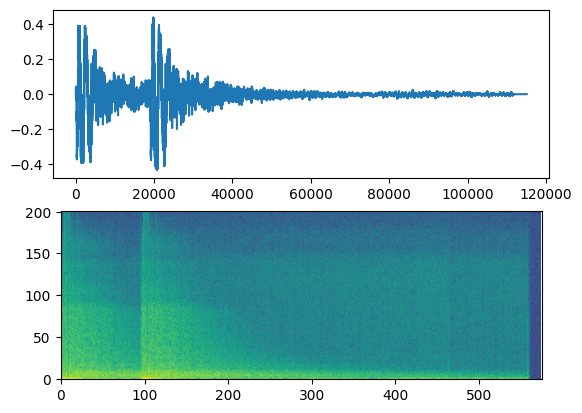

In [5]:
filename = "./UrbanSounds8K/fold1/102305-6-0-0.wav"
waveform, sample_rate = rechannel(torchaudio.load(filename), 1)
fig, axs = plt.subplots(2)
axs[0].plot(waveform.t().numpy())
show_spectrogram(waveform)

**Extended Audio**


Shape of spectrogram: torch.Size([201, 883])


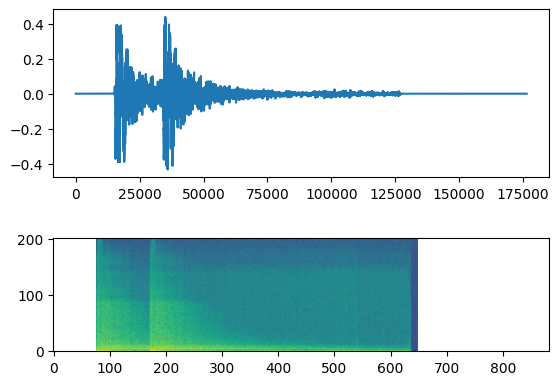

In [6]:
waveform, sr = pad_trunc(rechannel(torchaudio.load(filename),1), 4000)
fig, axs = plt.subplots(2)
axs[0].plot(waveform.t().numpy())
show_spectrogram(waveform)

In [7]:
ipd.Audio(waveform.numpy(), rate=sample_rate)

**Generate Spectrogram**

In [8]:
import os
import torch
import torchaudio
# import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
from PIL import Image

In [64]:
class_map = ['air conditioner', 'car horn', 'children playing', 'dog bark', 'drilling', 'engine idling', 'gunshot', 'jackhammer', 'siren', 'street music']

In [75]:
def load_audio_files(path, dataset):
    walker = [str(p) for p in Path(path).glob(f'*.wav')]
    for i, file_path in enumerate(walker):
        path, filename = os.path.split(file_path)
        title, _ = os.path.splitext(filename)
        fsID, classID, occurrenceID, sliceID = [int(n) for n in title.split('-')]
        # Load audio
        waveform, sample_rate = pad_trunc(resample(rechannel(torchaudio.load(file_path),1),44100),4000)
        assert waveform.shape == torch.Size(
            [1, 176400]), f'Error: waveform shape is {waveform.shape}'
        dataset.append([waveform[0], classID, title])

    return dataset

In [43]:
audio_dataset = []

main_path = './UrbanSounds8K/'

dir = [str(p) for p in Path(main_path).glob('fold*')][0:-1]
test_val = dir[0:2]

for path in test_val:
    print("Loading ", path)
    audio_dataset = load_audio_files(path, audio_dataset)

print(f"Length of dataset: {len(audio_dataset)}")

['UrbanSounds8K\\fold1', 'UrbanSounds8K\\fold10', 'UrbanSounds8K\\fold2', 'UrbanSounds8K\\fold3', 'UrbanSounds8K\\fold4', 'UrbanSounds8K\\fold5', 'UrbanSounds8K\\fold6', 'UrbanSounds8K\\fold7', 'UrbanSounds8K\\fold8']


SyntaxError: 'break' outside loop (1831830076.py, line 7)

In [12]:
# rm -rf ./UrbanSounds8K/spectrograms/ # remove all spectrograms

In [38]:
def create_spectrogram_images(trainloader, train=True):
    length = len(trainloader)
    spectrogram = torchaudio.transforms.Spectrogram()
    timeMask = torchaudio.transforms.TimeMasking(time_mask_param=80)
    freqMask = torchaudio.transforms.FrequencyMasking(freq_mask_param=80)
    num_TimeMask = 4
    num_FreqMask = 4
    num_FreqTimeMask = 4

    for i, data in enumerate(trainloader):
        waveform = data[0]
        classID = data[1].item()
        title = data[2][0]
        if train:
            directory = f'./UrbanSounds8K/spectrograms/train/{class_map[classID]}/'
        else:
            directory = f'./UrbanSounds8K/spectrograms/val/{class_map[classID]}/'
        if(not os.path.isdir(directory)):
            os.makedirs(directory, mode=0o777, exist_ok=True)

        spectrogram_tensor = (spectrogram(waveform) + 1e-12).log2()

        assert spectrogram_tensor.shape == torch.Size([1, 201, 883]), f"Spectrogram size mismatch! {spectrogram_tensor.shape}"
        
        if train:
            # create transformed waveforms
            for a in range(num_TimeMask):
                masked_spectrogram_tensor = timeMask(spectrogram_tensor)
                np.save(f'{directory}{title}-tm{a}_spec',
                        masked_spectrogram_tensor.flipud())

            for a in range(num_FreqMask):
                masked_spectrogram_tensor = freqMask(spectrogram_tensor)
                np.save(f'{directory}{title}-fm{a}_spec',
                        masked_spectrogram_tensor.flipud())

            for a in range(num_FreqTimeMask):
                masked_spectrogram_tensor = freqMask(timeMask(spectrogram_tensor))
                np.save(f'{directory}{title}-ftm{a}_spec',
                        masked_spectrogram_tensor.flipud())

        np.save(f'{directory}{title}-org_spec', spectrogram_tensor.flipud())
        # break
        if i % 1000 == 0:
            print(f'{i}/{length}')

    return (length-1)*(num_TimeMask + num_FreqMask + num_FreqTimeMask + 1) if train else (length)



train_size = int(0.8 * len(audio_dataset))
val_size = len(audio_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(
    audio_dataset, [train_size, val_size])

audio_dataloader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=1,
                                               shuffle=False,
                                               num_workers=0)

num_train = create_spectrogram_images(audio_dataloader, True)

audio_dataloader = torch.utils.data.DataLoader(val_dataset,
                                               batch_size=1,
                                               shuffle=False,
                                               num_workers=0)

num_val = create_spectrogram_images(audio_dataloader, False)

0/698
0/175


In [62]:
%%ipytest

def test_val_spectrogram_generation():
    assert len([
        str(p) for p in Path('./UrbanSounds8K/spectrograms/train').glob('*')
    ]) == len(class_map)

    sum = 0
    dir = [str(p) for p in Path('./UrbanSounds8K/spectrograms/train').glob('*')]
    for path in dir:
        num = len([str(p) for p in Path(path).glob('*')])
        sum += num
    assert sum == num_train

    assert len([
        str(p) for p in Path('./UrbanSounds8K/spectrograms/val').glob('*')
    ]) == len(class_map)

    sum = 0
    dir = [str(p) for p in Path('./UrbanSounds8K/spectrograms/val').glob('*')]
    for path in dir:
        num = len([str(p) for p in Path(path).glob('*')])
        sum += num

    assert sum == num_val

F                                                                                            [100%]
============================================ FAILURES =============================================
_________________________________ test_val_spectrogram_generation _________________________________

    def test_val_spectrogram_generation():
        assert len([
            str(p) for p in Path('./UrbanSounds8K/spectrograms/train').glob('*')
        ]) == len(class_map)
    
        sum = 0
        dir = [str(p) for p in Path('./UrbanSounds8K/spectrograms/train').glob('*')]
        for path in dir:
            num = len([str(p) for p in Path(path).glob('*')])
            sum += num
        assert sum == num_train
    
>       assert len([
            str(p) for p in Path('./UrbanSounds8K/spectrograms/val').glob('*')
        ]) == len(class_map)
E       AssertionError: assert 0 == 10
E        +  where 0 = len([])
E        +  and   10 = len(['air conditioner', 'car horn', 'children playi

Inspect a sample

-39.863136   10.584687


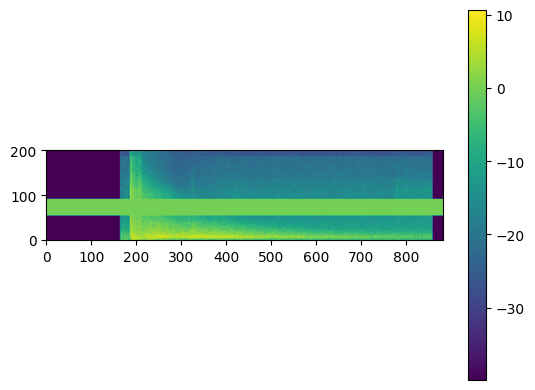

In [40]:
test_load = np.load(
        './UrbanSounds8K/spectrograms/train/gunshot/122690-6-0-0-fm0_spec.npy')
plt.imshow(test_load[0], origin="lower")
plt.colorbar()
print(test_load.min(), " ", test_load.max())

**Actual Machine Learning**

In [90]:
import os
import IPython.display as ipd
from IPython.display import Audio
import random
from torchvision import datasets, transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from torchvision import datasets, models, transforms
# from torchinfo import summary
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from pathlib import Path
import torchvision
from torch.utils.tensorboard import SummaryWriter

In [2]:
def npy_loader(path):
    sample = torch.from_numpy(np.load(path))
    return sample


audio_train_dataset = datasets.DatasetFolder(root='./UrbanSounds8K/spectrograms/train/',
                                       loader=npy_loader,
                                       extensions=['.npy'])

audio_val_dataset = datasets.DatasetFolder(root='./UrbanSounds8K/spectrograms/val/',
                                       loader=npy_loader,
                                       extensions=['.npy'])

print("Training size:", len(audio_train_dataset))
print("Validation size:",len(audio_val_dataset))

train_dataloader = torch.utils.data.DataLoader(audio_train_dataset,
                                               batch_size=16,
                                               num_workers=0,
                                               shuffle=True)

val_dataloader = torch.utils.data.DataLoader(audio_val_dataset,
                                              batch_size=16,
                                              num_workers=0,
                                              shuffle=True,
                                             )

import torch.nn.functional as F
from torch.nn import init

model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18')
model.conv1 = nn.Conv2d(1,
                        64,
                        kernel_size=(7, 7),
                        stride=(2, 2),
                        padding=(3, 3),
                        bias=False)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Check that it is on Cuda
next(model.parameters()).device

Training size: 9074
Validation size: 175


Using cache found in C:\Users\jianq/.cache\torch\hub\pytorch_vision_v0.10.0


device(type='cpu')

In [ ]:
# rm -rf ./logsdir/ # remove all logs

In [6]:
# cost function used to determine best parameters
cost = torch.nn.CrossEntropyLoss()

# used to create optimal parameters
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Create the training function
def train(dataloader, model, optimizer):
    train_size = len(dataloader.dataset)
    batch_size = len(next(iter(dataloader))[1])
    total_batch = len(dataloader)
    train_loss, train_accuracy = 0, 0

    model.train()

    for batch, (X, Y) in enumerate(dataloader):
        X, Y = X.to(device), Y.to(device)
        optimizer.zero_grad()
        pred = model(X)
        batch_loss = cost(pred, Y)
        batch_loss.backward()
        optimizer.step()
        batch_accuracy = (pred.argmax(1)==Y).type(torch.float).sum()
        train_loss += batch_loss.item()
        train_accuracy += batch_accuracy.item()
        if batch % 100 == 0:
            print(
                f"Training batch {batch}/{total_batch} -> Loss: {batch_loss.item()}  Accuracy: {batch_accuracy.item()/batch_size*100}%"
            )
    train_loss /= train_size
    train_accuracy /= train_size/100
    return(train_loss, train_accuracy)


# Create the validation function
def val(dataloader, model):
    val_size = len(dataloader.dataset)
    total_batch = len(dataloader)
    val_loss, val_accuracy = 0, 0

    model.eval()

    with torch.no_grad():
        for batch, (X, Y) in enumerate(dataloader):
            X, Y = X.to(device), Y.to(device)
            pred = model(X)
            batch_loss = cost(pred, Y)
            batch_accuracy = (pred.argmax(1)==Y).type(torch.float).sum()
            val_loss += batch_loss.item()
            val_accuracy += batch_accuracy.item()
        if batch % 10 == 0:
            print(
                f"Validation batch {batch}/{total_batch} -> Loss: {batch_loss.item()}  Accuracy: {batch_accuracy.item()/batch_size*100}%"
            )

    val_loss /= val_size
    val_accuracy /= val_size/100
    return(val_loss, val_accuracy)

Tensorboard model graph

In [5]:
import time
from datetime import datetime

title = datetime.now().strftime("%Y-%m-%d,%H-%M-%S")
# title="freqTimeFulldataset"

writer = SummaryWriter(f'./logs/{title}')
writer.close()

In [ ]:
def tensorBoardLogging(train_loss, train_accuracy, val_loss, val_accuracy, epoch):
    writer.add_scalar('1 Training/1 Model loss', train_loss, epoch)
    writer.add_scalar('1 Training/2 Model accuracy', train_accuracy, epoch)
    writer.add_scalar('2 Validate/1 Model loss', val_loss, epoch)
    writer.add_scalar('2 Validate/2 Model accuracy', val_accuracy, epoch)
    writer.close()

In [ ]:
import time

epochs = 20
for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}\n-------------------------------')
    start = time.time()
    train_loss, train_accuracy = train(train_dataloader, model, optimizer)
    val_loss, val_accuracy = val(val_dataloader, model)
    end = time.time()
    print(f"\nEpoch duration: {end - start} seconds")
    print(f'Training | Loss: {train_loss} Accuracy: {train_accuracy}%')
    print(f'Validating  | Loss: {val_loss} Accuracy: {val_accuracy}% \n')
    # tensorBoardLogging(train_loss, train_accuracy, val_loss, val_accuracy, epoch)

print('Done!')

Testing trained model

In [97]:
test_dataset = []
test_dataset = load_audio_files('./UrbanSounds8K/fold9/', test_dataset)

In [115]:
randIndex_list = torch.randint(0, len(test_dataset),(1,10))[0]

In [117]:
predicted = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

for i, randIndex in enumerate(randIndex_list):
    waveform, class_id, title = test_dataset[randIndex]
    writer.add_audio(
        f'Test/({title})A:{class_map[class_id]} P:{class_map[predicted[i]]}',
        waveform, 44100)

writer.close()

**Debugging**

In [62]:

# audio_dataset = []
# sum = 0

# main_path = './UrbanSounds8K/spectrograms/'

# dir = [str(p) for p in Path(main_path).glob('*')]
# for path in dir:
#   print('Loading: '+ path)
#   num = len([str(p) for p in Path(path).glob('*')])
#   sum += num
#   print(num)

# sum